# This is a demo of fitting linearizeable models and selecting best fit

In [4]:
%matplotlib inline
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from sklearn import linear_model as linmod

DEBUGGING = False

if DEBUGGING: 
    np.random.seed(0)

### The general idea:

6 linearizable models:

### 1. Straight-line: $Y = \alpha_0 + \alpha_1 * X$


![alt text](straight_line_up.png "Straight Line Model")

![alt text](straight_line_down.png "Straight Line Model")


### 2. **Exponential: $Y = \alpha_0 * e^{\left(\alpha_1 * X\right)}$**


![alt text](exponential_up.png "Exponential Increase illustration")

![alt text](exponential_down.png "Exponential Decrease illustration")



Take log of both sides:

$$ln(Y) = ln(\alpha_0) + \alpha_1 * X$$

Assign $Y' = ln(Y)$; $\beta_0 = ln(\alpha_0)$, and we have: 

$$Y' = \beta_0 + \alpha_1 * X$$

- a regular linear model.

### 3. **Power: $Y = \alpha_0 * X^{\alpha_1}$ - this includes hyperbolae: $\alpha_1 < 0$**


![alt text](power_up.png "Logarithmic illustration")
![alt text](hyperbola.png "Logarithmic illustration")
![alt text](power_lt1.png "Logarithmic illustration")

Take log of both sides:

$$ln(Y) = ln(\alpha_0) + \alpha_1 * ln(X)$$

Assign $Y' = ln(Y)$; $\beta_0 = ln(\alpha_0)$; $X' = ln(X)$, and we have: 

$$Y' = \beta_0 + \alpha_1 * X'$$

- a regular linear model.

### 4. **Logarithmic: $Y = \alpha_0 * ln{\left(\alpha_1 * X\right)}$**


![alt text](logarithmic.png "Logarithmic illustration")


Raise $e$ to the power of left and right side:

$$e^{Y} = e^{\alpha_0* ln{\left(\alpha_1 * X\right)}},$$
$$e^Y = (\alpha_1*X)^{\alpha_0};$$

Finally:
$$Y = \alpha_0^{\alpha_1} * X^{\alpha1}$$

- same as Power model => take log of both sides:

$$Y = ln(\alpha_0^{\alpha_1}) + \alpha_1 * ln(X)$$

Assign $\beta_0 = \alpha_1 * ln(\alpha_0)$; $X' = ln(X)$, and we have:

$$Y = \beta_1 + \alpha_1 * X'$$

- a regular linear model.

### 5. **Logistic: $Y = \alpha_0 + \alpha_1 * X$, $X\in[0...1]$**

![alt text](sigmoid.png "Sigmoid illustration")

We covered it in [Example 2](http://localhost:8888/notebooks/Dropbox/Intro%20to%20Machine%20Learning%20at%20CMG%202019/Worksheets/ipynb/example2%20-%20Logistic%20Regression.ipynb):

Assign $$X' = ln{\left[\frac{X}{1-X}\right]}$$,

and then we have:

$$Y = \alpha_0 + \alpha_1 * X'$$

- a regular linear model.

### 6. **Polynomial: $Y = \alpha_0 + \alpha_1 * X + \alpha_2 * X^2 + \alpha_3 * X^3 + ...$**

![alt text](quadratic.png "Polynomial illustration")

Here we dive into the world of ***multiple regression***: assign $X_1 = X$, $X_2 = X^2$, $X_3 = X^3$, ...

Then we have:

$$Y = \alpha_0 + \alpha_1 * X + \alpha_2 * X_2 + \alpha_3 * X_3 + ...$$ 
- a regular linear model, but in multiple dimensions.

### We are going to define some helper functions here:

In [18]:
def plot_the_data (X, Y, plot_title, file_name):
    
    fig, ax = plt.subplots(figsize=(8,5))
    plt.plot (X, Y)
    plt.scatter(X, Y)
    ax.set_xlabel('X', fontsize=14)
    ax.set_ylabel('Y', fontsize=14)
    ax.set_title(plot_title, fontsize=16)
    ax.tick_params(labelsize=12)
    plt.savefig(file_name)

In [19]:
def generate_the_plots():
    #####################################################################################################################
    '''Create an (X, Y) pair for illustration'''
    X = np.arange (1., 500., 0.5)
    Y = -3.0 * X + 3000
    plot_the_data(X, Y, 'Straight line', './straight_line_down.png')

    Y = 3.0 * X + 15
    plot_the_data(X, Y, 'Straight line', './straight_line_up.png')

    Y = -1.225 * np.power(X,2) + 300.0 * X + 15
    plot_the_data(X, Y, 'Polynomial (Quadratic)', './quadratic.png')


    Y = 1.5 * np.log(0.5*X)
    plot_the_data(X, Y, 'Logarithmic', './logarithmic.png')


    Y = 1.5 * np.exp(0.005*X)
    plot_the_data(X, Y, 'Exponential', './exponential_up.png')


    Y = 1.5 * np.exp(-0.005*X)
    plot_the_data(X, Y, 'Exponential', './exponential_down.png')


    Y = 1.5 * np.power(X, 3.5)
    plot_the_data(X, Y, 'Power', './power_up.png')


    Y = 1.5 * np.power(X, -0.15)
    plot_the_data(X, Y, 'Power', './hyperbola.png')

    Y = 1.5 * np.power(X, 0.25)
    plot_the_data(X, Y, 'Power', './power_lt1.png')


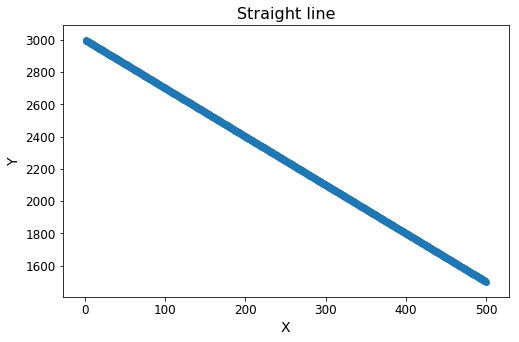

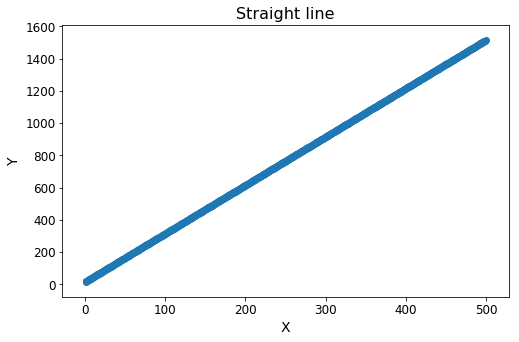

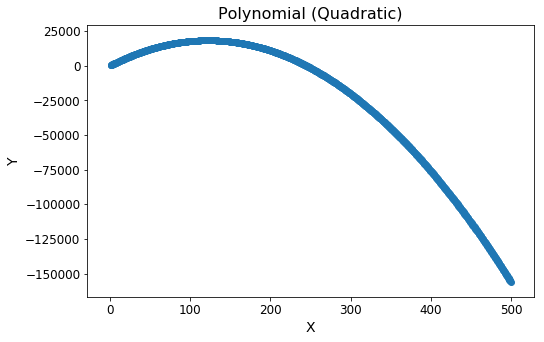

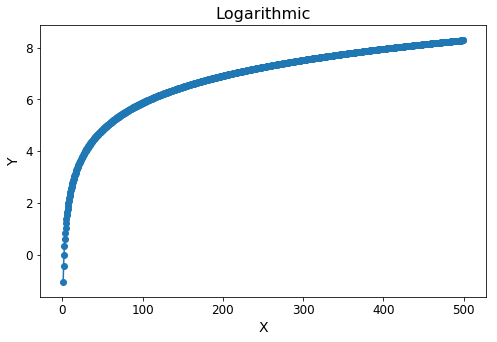

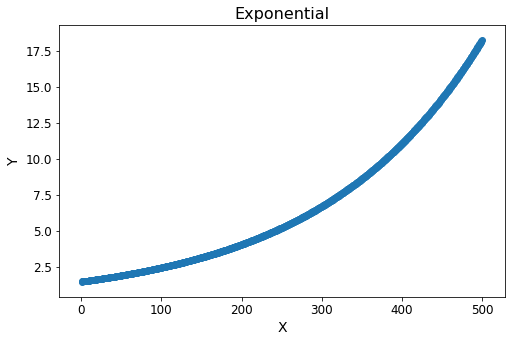

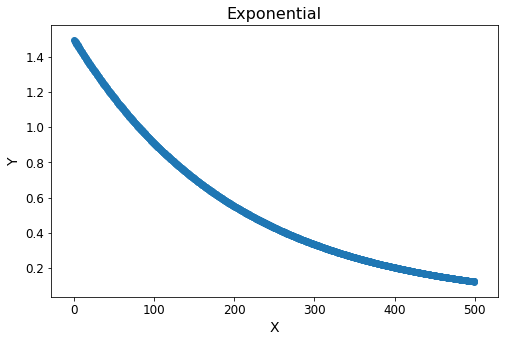

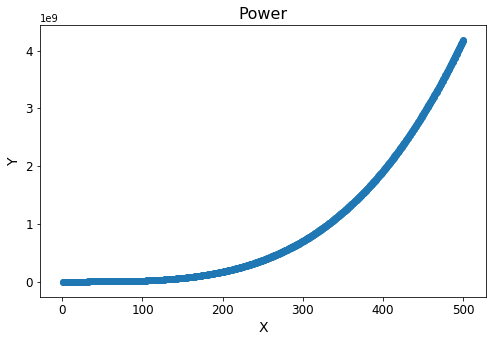

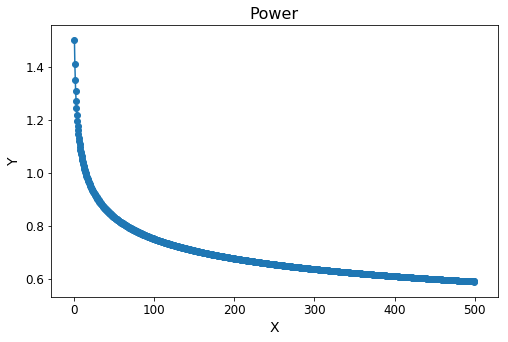

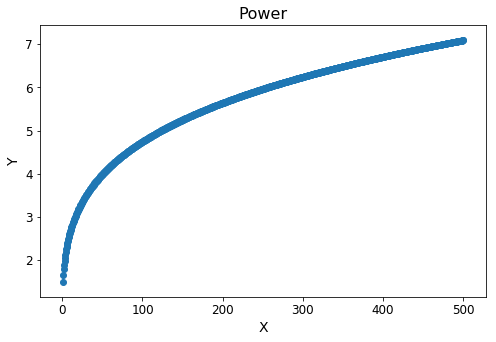

In [20]:
generate_the_plots()

### Now we are going to simulate a dataset and fit some models into it, 
### to demonstrate how to find the best model: 

In [175]:
X = [float(ii) for ii in range(500)]
len(X)

500

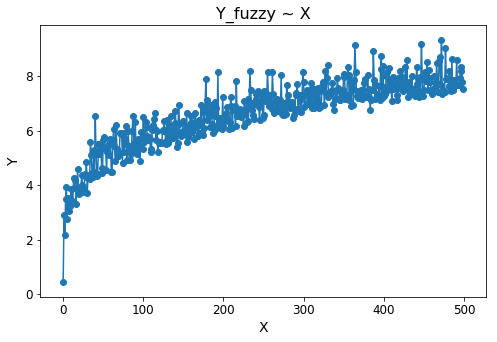

In [23]:
thedata = np.random.gamma(5, 1, len(X))
'''Add some noise'''
Y = 1.5 * np.power(X, 0.25)
Y_fuzzy = [list(Y) [ii] + 0.2 * list(thedata)[ii] for ii in range(len(list(Y)))]
plot_the_data(X, Y_fuzzy, 'Y_fuzzy ~ X', './power_curve_withnoise.png')


In [176]:
import pandas as pd
myX = list(X)
mydf = pd.DataFrame.from_dict({'X': myX, 'Y': Y_fuzzy})
mydf.head()

,X,Y
0,0.0,0.465355
1,1.0,2.908960
2,2.0,2.189079
3,3.0,3.497573
4,4.0,3.919521


In [178]:
import statsmodels.formula.api as smf

"""Fit Linear Model (straight-line)"""
myregr = smf.ols('Y ~ X', data = mydf)
lin = myregr.fit()
print(lin.summary())

linMdlPrediction = lin.predict()

"""Fit Quadratic Model"""
myregr = smf.ols('Y ~ X + np.power(X, 2)', data = mydf)
quad = myregr.fit()
print(quad.summary())
print(list(quad.params))
quadMdlPrediction = quad.predict()


"""Fit 4th-Order Polynomial"""
myregr = smf.ols('Y ~ X + np.power(X, 2) + np.power(X, 3) + np.power(X, 4)' , data = mydf)
parabola = myregr.fit()
print(parabola.summary())
print(list(parabola.params))
parabolaMdlPrediction = parabola.predict()


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     1503.
Date:                Wed, 09 Jan 2019   Prob (F-statistic):          1.61e-152
Time:                        20:58:08   Log-Likelihood:                -469.22
No. Observations:                 500   AIC:                             942.4
Df Residuals:                     498   BIC:                             950.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7661      0.055     86.114      0.0

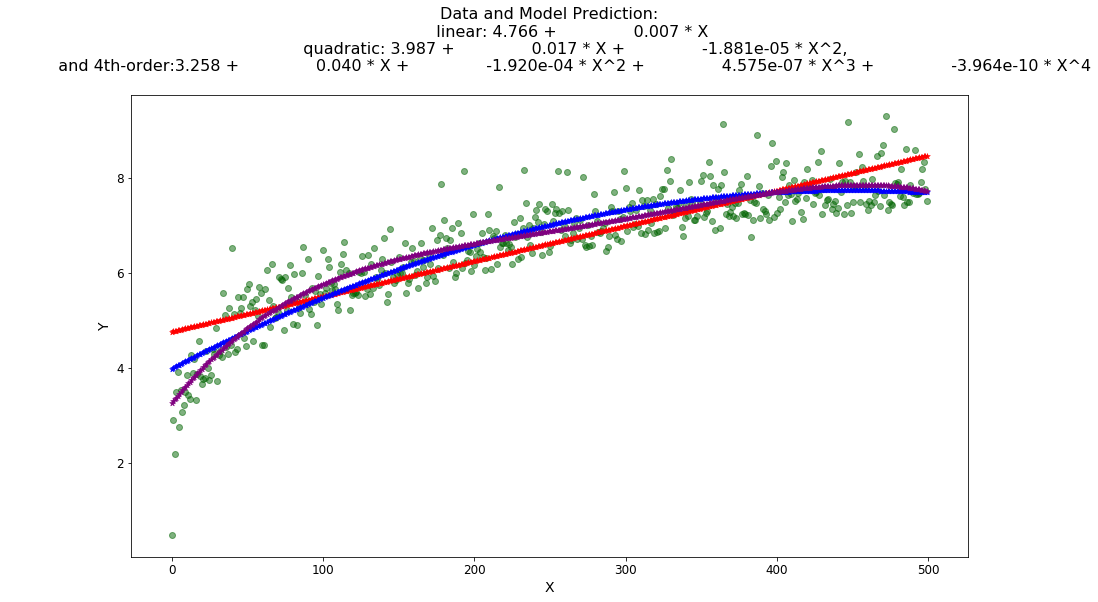

In [179]:
#####################################################################################################################
'''Show fuzzy data and regression line'''
fig, ax = plt.subplots(figsize=(15,8.5))
plt.scatter(X, Y_fuzzy, marker = 'o', color='darkgreen', alpha=0.5)
plt.scatter(X, linMdlPrediction, color='red',marker='*', linewidths=0.5)
plt.scatter(X, quadMdlPrediction, color='blue',marker='*', linewidths=0.5)
plt.scatter(X, parabolaMdlPrediction, color='purple',marker='*', linewidths=0.5)
plt.title(f"""Data and Model Prediction:
          linear: {'%5.3f' % (list(lin.params)[0])} + \
              {'%5.3f' % (list(lin.params)[1])} * X 
          quadratic: {'%5.3f' % (list(quad.params)[0])} + \
              {'%5.3f' % (list(quad.params)[1])} * X + \
              {'%5.3e' % (list(quad.params)[2])} * X^2,
          and 4th-order:{'%5.3f' % (list(parabola.params)[0])} + \
              {'%5.3f' % (list(parabola.params)[1])} * X + \
              {'%5.3e' % (list(parabola.params)[2])} * X^2 + \
              {'%5.3e' % (list(parabola.params)[3])} * X^3 + \
              {'%5.3e' % (list(parabola.params)[4])} * X^4
          """  
          , fontsize=16)
ax.set_xlabel('X', fontsize=14)
ax.set_ylabel('Y', fontsize=14)
# ax.set_title('Scatterplot', fontsize=16)
ax.tick_params(labelsize=12)
plt.show()

All 3 lines are linear (OLS) regression; red is straight-line model; blue is second-order polynomial, and purple is fourth-order polynomial.  It's obvious which is a better fit from visualisation, but how can we find it programmatically without training a neural network to recognize visual patterns? 

##### Which is the best fit for these data?

We already know that $R^2$ is important: it is the proportion of variance in the $Y$ that is explained by the model.  Let's look at the $R^2$ and $adjusted R^2$ for the 3 models:

In [71]:
modelFit = pd.DataFrame.from_dict({'model': ['linear', 'quadratic', '4th_degree'],
                                  'r_squared': [lin.rsquared, quad.rsquared, parabola.rsquared],
                                   'adj_r_squared': [lin.rsquared_adj, quad.rsquared_adj, parabola.rsquared_adj]})
modelFit

,model,r_squared,adj_r_squared
0,linear,0.751141,0.750642
1,quadratic,0.831037,0.830357
2,4th_degree,0.854002,0.852822


Let's first explore what this adjustment is

In [72]:
modelFit['adjustment'] = modelFit['r_squared'] - modelFit['adj_r_squared']
modelFit

,model,r_squared,adj_r_squared,adjustment
0,linear,0.751141,0.750642,0.00050
1,quadratic,0.831037,0.830357,0.00068
2,4th_degree,0.854002,0.852822,0.00118


It is the smallest for linear, a little bigger for quadratic, and the biggest for the 4th-degree polynomial.  $R^2$ adjustment reduces the fit measure for ***model complexity***.  

Linear is the simplest model - only 2 parameters; minimum adjustment.  Fourth-degree polynomial is the most complex of the three models - 5 parameters.  For it, the adjustment is the biggest.  

There are other techniques to penalize complexity.  Look into Lasso regression, Ridge regression, and others.
These techniques are outside the scope of this class.

Why are we worried about model complexity?  We don't want to **overfit the model**.  When we have 2 data points, we can only draw a single straight line through it, with 3, only one quadratic parabola, with 4, only one cubic parabola, etc.  But the predictive power of this mode would be poor: we will not know how well it will predict data it has not seen.  A cubic parabola is an ***overfit*** for a data set of 4 points.

##### Now back to our modelFit dataframe

Intuitively, it is clear that quadratic is a better fit than linear, and a higher-degree polynomial *may be* a better fit than quadratic.  To make the call based on $R^2$ or $adjusted R^2$, we need to use a technique described by Roland Fisher, called the Z-transformation (not to be confused with Laplace Z-transformation). Fisher's transformation makes this unknown distribution Normal.  

The formula for $z$ - the mean of the transformed distribution is:

$$ z = \frac{1}{2} * ln\left(\frac{1+\rho}{1-\rho}\right) = arctanh(\rho)$$

The formula for its standard deviation is:

$$s = \frac{\sigma}{\sqrt{N}} = \frac{1}{\sqrt{N - 3}}$$

As you recall, $R^2 = \rho^2$, where $\rho$ is the estimate of the correlation coefficient between observed and predicted values of $Y$.  As a coefficient, it is a random variable, with an unknown distribution.  Do we **know** that, if $0.853 > 0.830$, the ***distributions represented by*** these values are really different?

Some details are [here in Wikipedia](https://en.wikipedia.org/wiki/Fisher_transformation).

Let's follow it and see which model is better.  We will use $adjusted R^2$

In [73]:
modelFit['adj_rho'] = np.sqrt(modelFit['adj_r_squared'])
modelFit['adj_z'] = np.arctanh(modelFit['adj_rho'])
modelFit['N'] = len(X)
modelFit['std_err'] = 1.0/np.sqrt(modelFit['N'] - 3.0)
modelFit

,model,r_squared,adj_r_squared,adjustment,adj_rho,adj_z,N,std_err
0,linear,0.751141,0.750642,0.00050,0.866396,1.318441,500,0.044856
1,quadratic,0.831037,0.830357,0.00068,0.911239,1.534782,500,0.044856
2,4th_degree,0.854002,0.852822,0.00118,0.923484,1.612195,500,0.044856


Now we have 3 normally distributed variables, and we can sequentially select the best model by simulating Normal distribution and conducting the T-test on them.  Or we can take them directly into the formula for the T-test:

$$T_{obs} = \frac{\mu_1 - \mu_2}{s}$$

$T_{critical}(N, \alpha)$ is available from tables and from most statistical software

Ttest_indResult(statistic=-77.01059871196715, pvalue=0.0)
quadratic is better than linear


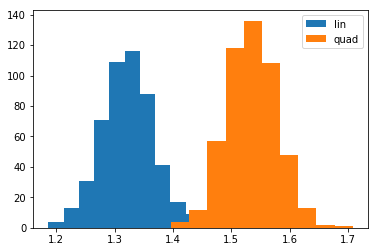

In [174]:
"""
Compare linear vs. quadratic
"""
linFit = modelFit.loc[modelFit['model']=='linear'].copy()
linFit
quadFit= modelFit.loc[modelFit['model']=='quadratic'].copy()
quadFit

np.random.seed(1234567)
lin_rvs = np.random.normal(float(linFit['adj_z']), 
                    float(linFit['std_err']),
                    int(linFit['N'])-1
                   )
plt.hist(lin_rvs, label='lin')

quad_rvs = np.random.normal(float(quadFit['adj_z']), 
                    float(quadFit['std_err']),
                    int(quadFit['N'])-1
                   )
plt.hist(quad_rvs, label='quad')
plt.legend(loc="best")
ttest = stats.ttest_ind(lin_rvs, quad_rvs)

print (ttest)

if list(ttest)[1] <= 0.05:
    if list(ttest)[0] < 0:
        print ('quadratic is better than linear')
    else:
        print ('linear is better than quadratic')
else:
    print ('linear and quadratic models are about same')

Ttest_indResult(statistic=-29.00280105256318, pvalue=1.2369000736193323e-134)
4th-order polynomial is better than quadratic


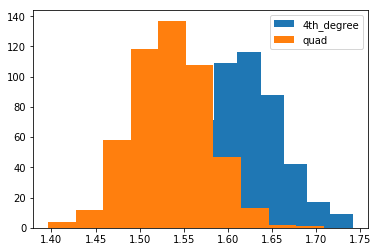

In [173]:
"""
Compare quadratic vs. 4th-order polynomial
"""
quadFit= modelFit.loc[modelFit['model']=='quadratic'].copy()
quadFit

polyFit= modelFit.loc[modelFit['model']=='4th_degree'].copy()
polyFit

np.random.seed(1234567)
poly_rvs = np.random.normal(float(polyFit['adj_z']), 
                    float(polyFit['std_err']),
                    int(polyFit['N'])
                   )
plt.hist(poly_rvs, label='4th_degree')

quad_rvs = np.random.normal(float(quadFit['adj_z']), 
                    float(quadFit['std_err']),
                    int(quadFit['N'])
                   )
plt.hist(quad_rvs, label='quad')
plt.legend(loc="best")
ttest = stats.ttest_ind(quad_rvs, poly_rvs)

print (ttest)

if list(ttest)[1] <= 0.05:
    if list(ttest)[0] < 0:
        print ('4th-order polynomial is better than quadratic')
    else:
        print ('quadratic is better than 4th-order polynomial')
else:
    print ('4th-order polynomial and quadratic models are about same')

A detailed explanation of T-test is here: https://stattrek.com/hypothesis-test/difference-in-means.aspx

### This was the way to select the best model based on  $adjusted R^2$